# License 
***
Copyright (C) 2017 J. Patrick Hall, jphall@gwu.edu

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

***
# Kaggle House Prices with GLRM Matrix Factorization Example

## Imports and inits

In [1]:
import h2o
from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch 
h2o.init(max_mem_size='12G') # give h2o as much memory as possible
h2o.no_progress() # turn off h2o progress bars

import matplotlib as plt
%matplotlib inline
import numpy as np
import pandas as pd

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_112"; Java(TM) SE Runtime Environment (build 1.8.0_112-b16); Java HotSpot(TM) 64-Bit Server VM (build 25.112-b16, mixed mode)
  Starting server from /Users/phall/anaconda/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpyvknifvq
  JVM stdout: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpyvknifvq/h2o_phall_started_from_python.out
  JVM stderr: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpyvknifvq/h2o_phall_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


--------------------------  ------------------------------
H2O cluster uptime:         01 secs
H2O cluster version:        3.12.0.1
H2O cluster version age:    13 days
H2O cluster name:           H2O_from_python_phall_zjwl7o
H2O cluster total nodes:    1
H2O cluster free memory:    10.67 Gb
H2O cluster total cores:    8
H2O cluster allowed cores:  8
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
Python version:             3.5.2 final
--------------------------  ------------------------------

## Helper Functions

#### Determine data types

In [2]:
def get_type_lists(frame, rejects=['Id', 'SalePrice']):

    """Creates lists of numeric and categorical variables.
    
    :param frame: The frame from which to determine types.
    :param rejects: Variable names not to be included in returned lists.
    :return: Tuple of lists for numeric and categorical variables in the frame.
    
    """
    
    nums, cats = [], []
    for key, val in frame.types.items():
        if key not in rejects:
            if val == 'enum':
                cats.append(key)
            else: 
                nums.append(key)
                
    print('Numeric =', nums)                
    print()
    print('Categorical =', cats)
    
    return nums, cats

#### Impute with GLRM

In [3]:
def glrm_num_impute(role, frame):

    """ Helper function for imputing numeric variables using GLRM.
    
    :param role: Role of frame to be imputed.
    :param frame: H2OFrame to be imputed.
    :return: H2OFrame of imputed numeric features.
    
    """
    
    # count missing values in training data numeric columns
    print(role + ' missing:\n', [cnt for cnt in frame.nacnt() if cnt != 0.0])

    # initialize GLRM
    matrix_complete_glrm = H2OGeneralizedLowRankEstimator(
        k=10,                    # create 10 features 
        transform='STANDARDIZE', # <- seems very important
        gamma_x=0.001,           # regularization on values in X
        gamma_y=0.05)            # regularization on values in Y

    # train GLRM
    matrix_complete_glrm.train(training_frame=frame, x=original_nums)

    # plot iteration history to ensure convergence
    matrix_complete_glrm.score_history().plot(x='iteration', y='objective', title='GLRM Score History')

    # impute numeric inputs by multiply the calculated xi and yj for the missing values in train
    num_impute = matrix_complete_glrm.predict(frame)

    # count missing values in imputed set
    print('imputed ' + role + ' missing:\n', [cnt for cnt in num_impute.nacnt() if cnt != 0.0])
    
    return num_impute

#### Embed with GLRM 

In [4]:
def glrm_cat_embed(frame):
    
    """ Helper function for embedding caetgorical variables using GLRM.
    
    :param frame: H2OFrame to be embedded.
    :return: H2OFrame of embedded categorical features.
    
    """
    
    # initialize GLRM
    cat_embed_glrm = H2OGeneralizedLowRankEstimator(
        k=50,
        transform='STANDARDIZE',
        loss='Quadratic',
        regularization_x='Quadratic',
        regularization_y='L1',
        gamma_x=0.25,
        gamma_y=0.5)

    # train GLRM
    cat_embed_glrm.train(training_frame=frame, x=cats)

    # plot iteration history to ensure convergence
    cat_embed_glrm.score_history().plot(x='iteration', y='objective', title='GLRM Score History')

    # extracted embedded features
    cat_embed = h2o.get_frame(cat_embed_glrm._model_json['output']['representation_name'])
    
    return cat_embed

## Import data

In [5]:
train = h2o.import_file('../../03_regression/data/train.csv')
test = h2o.import_file('../../03_regression/data/test.csv')

# bug fix - from Keston
dummy_col = np.random.rand(test.shape[0])
test = test.cbind(h2o.H2OFrame(dummy_col))
cols = test.columns
cols[-1] = 'SalePrice'
test.columns = cols
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 81)


In [6]:
original_nums, cats = get_type_lists(train)

Numeric = ['Fireplaces', 'MSSubClass', 'BsmtFinSF2', 'MoSold', 'BsmtFullBath', 'BsmtUnfSF', 'YrSold', 'ScreenPorch', 'MasVnrArea', 'GarageCars', 'TotRmsAbvGrd', 'BedroomAbvGr', '3SsnPorch', 'YearRemodAdd', '1stFlrSF', 'BsmtHalfBath', 'WoodDeckSF', 'BsmtFinSF1', 'PoolArea', 'LotFrontage', '2ndFlrSF', 'OpenPorchSF', 'KitchenAbvGr', 'GrLivArea', 'LotArea', 'YearBuilt', 'TotalBsmtSF', 'HalfBath', 'GarageYrBlt', 'FullBath', 'MiscVal', 'OverallCond', 'EnclosedPorch', 'GarageArea', 'LowQualFinSF', 'OverallQual']

Categorical = ['Exterior1st', 'BldgType', 'BsmtExposure', 'MiscFeature', 'HeatingQC', 'GarageFinish', 'LandSlope', 'RoofMatl', 'Alley', 'Fence', 'Electrical', 'Exterior2nd', 'PoolQC', 'CentralAir', 'FireplaceQu', 'SaleType', 'MasVnrType', 'LandContour', 'ExterCond', 'MSZoning', 'LotConfig', 'Condition1', 'Foundation', 'Condition2', 'BsmtFinType1', 'HouseStyle', 'GarageQual', 'Functional', 'BsmtCond', 'GarageType', 'GarageCond', 'LotShape', 'RoofStyle', 'BsmtFinType2', 'SaleCondition'

## Split into to train and validation (before doing data prep!!!)

In [7]:
train, valid = train.split_frame([0.7], seed=12345)
print(train.shape)
print(valid.shape)

(1001, 81)
(459, 81)


## Impute numeric missing using GLRM matrix completion

#### Training data

training missing:
 [179.0, 7.0, 48.0]
imputed training missing:
 []


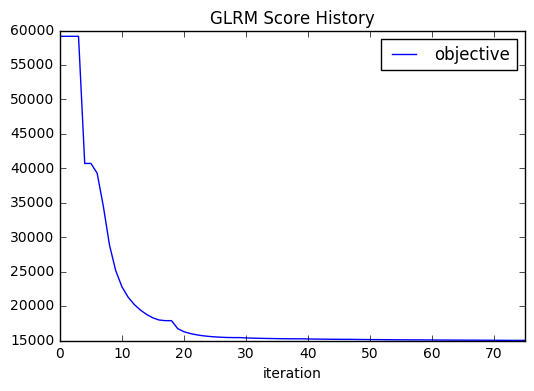

In [8]:
train_num_impute = glrm_num_impute('training', train)

#### Validation data

validation missing:
 [80.0, 1.0, 33.0]
imputed validation missing:
 []


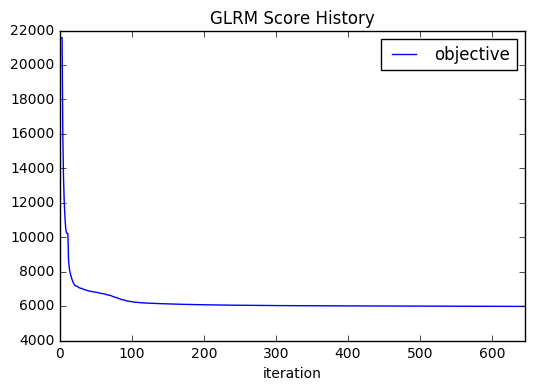

In [9]:
valid_num_impute = glrm_num_impute('validation', valid)

#### Test data

test missing:
 [227.0, 15.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 78.0, 1.0, 1.0]
imputed test missing:
 []


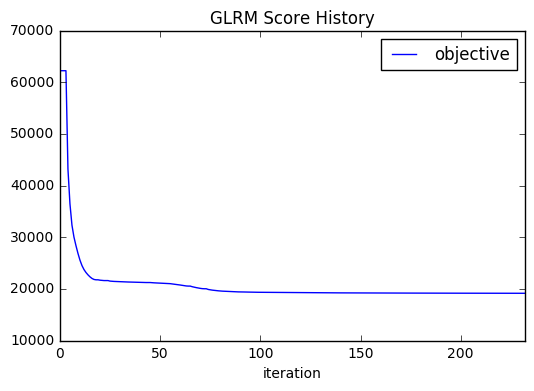

In [10]:
test_num_impute = glrm_num_impute('test', test)

## Embed categorical vars using GLRM

#### Training data

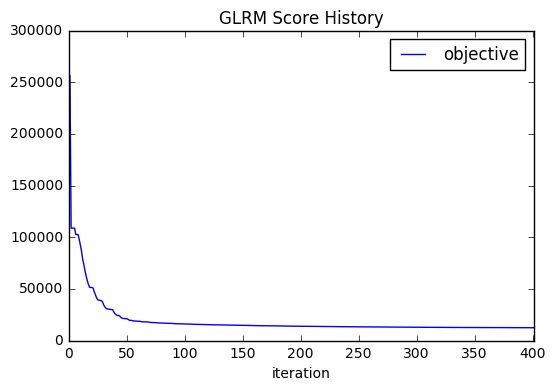

In [11]:
train_cat_embed = glrm_cat_embed(train)

#### Validation data

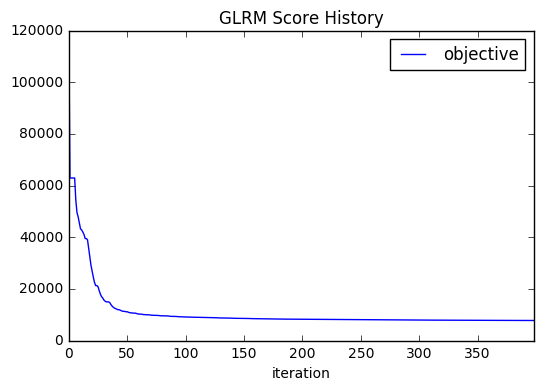

In [12]:
valid_cat_embed = glrm_cat_embed(valid)

#### Test data

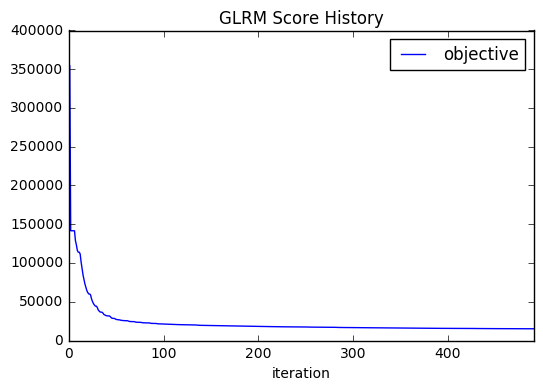

In [13]:
test_cat_embed = glrm_cat_embed(test)

## Merge imputed and embedded frames

In [14]:
imputed_embedded_train = train[['Id', 'SalePrice']].cbind(train_num_impute).cbind(train_cat_embed)
imputed_embedded_valid = valid[['Id', 'SalePrice']].cbind(valid_num_impute).cbind(valid_cat_embed)
imputed_embedded_test = test[['Id', 'SalePrice']].cbind(test_num_impute).cbind(test_cat_embed)

#### Redefine numerics and explore

In [15]:
imputed_embedded_nums, cats = get_type_lists(imputed_embedded_train)

Numeric = ['reconstr_MSSubClass', 'Arch7', 'Arch15', 'reconstr_TotalBsmtSF', 'reconstr_BsmtFullBath', 'reconstr_HalfBath', 'Arch27', 'reconstr_LowQualFinSF', 'Arch47', 'reconstr_YrSold', 'reconstr_OverallQual', 'Arch31', 'Arch41', 'Arch10', 'reconstr_BsmtHalfBath', 'Arch24', 'reconstr_OpenPorchSF', 'reconstr_TotRmsAbvGrd', 'Arch2', 'reconstr_LotFrontage', 'Arch26', 'Arch32', 'Arch48', 'reconstr_MasVnrArea', 'reconstr_BsmtUnfSF', 'reconstr_Fireplaces', 'Arch9', 'Arch12', 'reconstr_MoSold', 'reconstr_YearRemodAdd', 'Arch17', 'Arch6', 'Arch30', 'Arch13', 'reconstr_KitchenAbvGr', 'Arch8', 'Arch1', 'Arch37', 'reconstr_ScreenPorch', 'reconstr_OverallCond', 'Arch28', 'Arch42', 'reconstr_GarageCars', 'reconstr_BedroomAbvGr', 'Arch3', 'Arch40', 'reconstr_WoodDeckSF', 'Arch45', 'Arch39', 'reconstr_LotArea', 'Arch16', 'reconstr_YearBuilt', 'Arch11', 'Arch4', 'reconstr_EnclosedPorch', 'reconstr_GarageYrBlt', 'Arch18', 'Arch43', 'reconstr_BsmtFinSF2', 'reconstr_MiscVal', 'Arch29', 'Arch25', 'Arch20

In [16]:
print('Imputed and encoded numeric training data:')
imputed_embedded_train.describe() 
print('--------------------------------------------------------------------------------')
print('Imputed and encoded numeric validation data:')
imputed_embedded_valid.describe() 
print('--------------------------------------------------------------------------------')
print('Imputed and encoded numeric test data:')
imputed_embedded_test.describe()

Imputed and encoded numeric training data:
Rows:1001
Cols:88




Id SalePrice reconstr_MSSubClass reconstr_LotFrontage reconstr_LotArea reconstr_OverallQual reconstr_OverallCond reconstr_YearBuilt reconstr_YearRemodAdd reconstr_MasVnrArea reconstr_BsmtFinSF1 reconstr_BsmtFinSF2 reconstr_BsmtUnfSF reconstr_TotalBsmtSF reconstr_1stFlrSF reconstr_2ndFlrSF reconstr_LowQualFinSF reconstr_GrLivArea reconstr_BsmtFullBath reconstr_BsmtHalfBath reconstr_FullBath reconstr_HalfBath reconstr_BedroomAbvGr reconstr_KitchenAbvGr reconstr_TotRmsAbvGrd reconstr_Fireplaces reconstr_GarageYrBlt reconstr_GarageCars reconstr_GarageArea reconstr_WoodDeckSF reconstr_OpenPorchSF reconstr_EnclosedPorch reconstr_3SsnPorch reconstr_ScreenPorch reconstr_PoolArea reconstr_MiscVal reconstr_MoSold reconstr_YrSold Arch1 Arch2 Arch3 Arch4 Arch5 Arch6 Arch7 Arch8 Arch9 Arch10 Arch11 Arch12 Arch13 Arch14 Arch15 Arch16 Arch17 Arch18 Arch19 Arch20 Arch21 Arch22 Arch23 Arch24 Arch25 Arch26 Arch27 Arch28 Arch29 Arch30 Arch31 Arch32 Arch33 Arch34 Arch35 Arch36 Arch37 Arch38 Arch39 Arch40 Arch41 Arch42 Arch43 Arch44 Arch45 Arch46 Arch47 Arch48 Arch49 Arch50 
 
 
 type int int real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real 
 mins 1.0 34900.0 -2.0232038554574485 -1.7811990306674073 -1.6506495225780449 -2.0694039076808606 -1.5262047221853567 -2.528136244462111 -1.7768373659230206 -1.93553024971389 -1.4966460702421187 -2.0984861940704196 -2.681388177418833 -1.9245411716327436 -2.0413597213943158 -1.6793935347189466 -0.835256939909034 -2.2134696968624077 -1.8173281250391267 -1.590774884255996 -1.7303564746637654 -2.1609727693604155 -1.8343826303129436 -1.5009232799887835 -2.423641531347214 -2.4762366205899595 -2.4557267315827014 -2.087260239289245 -2.006463338654779 -1.5402753829878235 -1.128287391885987 -1.5221910172484163 -0.833324802922095 -1.641389211371227 -1.040275694869055 -1.184970268871101 -2.856987006737455 -3.3607681760259465 -0.5385739596342372 -0.5428686452038467 -0.527043489292618 -0.4019174240137737 -0.5051533092900511 -0.5502251259717398 -0.5427556172166872 -0.4716979740138766 -0.5726199074286575 -0.5638115948372815 -0.49347192206080465 -0.4588777216311955 -0.5821642787060395 -0.5068407640421927 -0.5182988746558768 -0.5576827167616889 -0.5556088647718916 -0.5422271040472367 -0.3977356679149917 -0.5538124733139743 -0.5681812699462467 -0.5133532832069291 -0.5352505232307594 -0.4703037805982998 -0.5206391980212789 -0.7058018725872854 -0.4711615736341193 -0.5223310722047697 -0.4391035794262717 -0.5392840432000022 -0.5155053123482718 -0.6969998247884078 -0.3445576692232503 -0.46143128459801375 -0.42072107090824457 -0.8502309863638875 -0.5415308686441523 -0.5931001897254388 -0.607297175963316 -0.547503466565454 -0.5820836507095432 -0.6420938298436424 -0.4620077310468372 -0.823601097181706 -0.5920831732201596 -0.47286142682326177 -0.6609504281077125 -0.47863252381812565 -0.47649747241909635 -0.6651048899349281 
 mean 724.8291708291708 182171.95904095905 0.004944478988623205 0.022291838880167423 -0.002433663317339395 0.007187417927257428 -0.007047332742830687 -0.0020979466125457744 -0.0006683393556987478 0.01089846838681526 -0.0034156788690723333 -0.007247704262161432 0.0025623646127736627 -0.0034101576206895345 -0.0006625884117077494 -0.0001027978663308402 -0.01210325797579643 -0.001737338244935443 0.0026078143343858393 0.004345052242230456 0.004678536388124521 -0.001453712034968583 -0.008427728364754661 0.003952838589320321 -0.0035002302341801007 0.0041671961957760965 -0.08023934373926232 0.005627132293908103 0.0003911429290805586 -0.0010239523643272384 0.0013862227845112002 0.00466885203410757 0.0012065537081257815 0.005718640963872881 0.00487891178

--------------------------------------------------------------------------------
Imputed and encoded numeric validation data:
Rows:459
Cols:88




Id SalePrice reconstr_MSSubClass reconstr_LotFrontage reconstr_LotArea reconstr_OverallQual reconstr_OverallCond reconstr_YearBuilt reconstr_YearRemodAdd reconstr_MasVnrArea reconstr_BsmtFinSF1 reconstr_BsmtFinSF2 reconstr_BsmtUnfSF reconstr_TotalBsmtSF reconstr_1stFlrSF reconstr_2ndFlrSF reconstr_LowQualFinSF reconstr_GrLivArea reconstr_BsmtFullBath reconstr_BsmtHalfBath reconstr_FullBath reconstr_HalfBath reconstr_BedroomAbvGr reconstr_KitchenAbvGr reconstr_TotRmsAbvGrd reconstr_Fireplaces reconstr_GarageYrBlt reconstr_GarageCars reconstr_GarageArea reconstr_WoodDeckSF reconstr_OpenPorchSF reconstr_EnclosedPorch reconstr_3SsnPorch reconstr_ScreenPorch reconstr_PoolArea reconstr_MiscVal reconstr_MoSold reconstr_YrSold Arch1 Arch2 Arch3 Arch4 Arch5 Arch6 Arch7 Arch8 Arch9 Arch10 Arch11 Arch12 Arch13 Arch14 Arch15 Arch16 Arch17 Arch18 Arch19 Arch20 Arch21 Arch22 Arch23 Arch24 Arch25 Arch26 Arch27 Arch28 Arch29 Arch30 Arch31 Arch32 Arch33 Arch34 Arch35 Arch36 Arch37 Arch38 Arch39 Arch40 Arch41 Arch42 Arch43 Arch44 Arch45 Arch46 Arch47 Arch48 Arch49 Arch50 
 
 
 type int int real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real 
 mins 4.0 39300.0 -4.423387845174533 -2.596554195551153 -1.7230195007360458 -2.510568797138346 -2.2436582178833735 -3.260586463546571 -2.2797275736157294 -1.9116478322383794 -1.5600593749270197 -1.9438058150962931 -2.3972388855963396 -2.1463530513388216 -2.3715485317307428 -1.3044059660143759 -3.2393571318212686 -2.5461066535276897 -1.4152546140122304 -1.9284716040482528 -2.1418280711137245 -1.8819797866219388 -1.9553351399503334 -1.8075705950059207 -2.1725511041502483 -1.6564244727956776 -2.732250937359515 -2.043352756573677 -2.082249968936931 -1.9111485128305612 -1.8754020355545413 -1.836160633217118 -1.6245934067425987 -1.2679082592990696 -1.6389959238184049 -1.7696425777656568 -5.272088348728062 -3.884829123523188 -0.584732886549403 -0.9503751305228025 -0.9686148241261533 -0.5175273541446563 -0.7133473903064621 -0.48093616764143426 -0.6097834496255043 -0.6278855381190404 -0.47260773742013634 -0.47119571895958956 -0.5778683033429259 -0.3543021002301245 -0.9803460916894432 -0.48455718580417106 -0.5281833916528744 -0.5640282734067216 -0.4064354713939931 -0.8337869528114371 -0.5692169206867621 -0.6607411592217625 -1.011321213427637 -0.7911718854349472 -0.7622696370015017 -0.5952499261354869 -0.574385020784396 -0.7127608968192053 -0.7541149670288531 -0.8837964945705651 -0.5535344143529289 -0.5806507791797633 -0.6540898207437251 -0.6931985024038534 -0.7422789164659868 -0.497482777242953 -0.42657417470848835 -0.7093854653566739 -0.5259459676417166 -0.6058666446469821 -0.5759456765770312 -0.6647997505214761 -0.519199413821221 -0.5175280919259501 -0.6112342249628672 -0.647339636173661 -0.6466711235490119 -0.6621097371815453 -0.5387403117697804 -0.40648570468940093 -0.4672854180238018 -0.7700912535670921 
 mean 742.8671023965142 178193.49673202613 -0.00866589388877508 0.006255721635326885 0.0057210567385798435 -0.00814655300641235 0.004216686454508484 -0.02001007878612845 -0.01683984808366013 -0.0013054247552597954 0.0018701930731986867 0.0025271524499522204 -0.00287878816614598 4.7858069447612986e-05 0.00446987921144735 -0.00311709159841792 0.008962225363267979 0.0013027440290037074 0.0013681261120129019 -0.00043680152853758334 -0.009627021468344347 -0.00853389698321965 0.007303671625077299 -0.0012250972974369358 0.002038552809914897 0.005066435839611155 -0.02034930399772678 -0.009818772992182088 -0.007316820112636103 -0.004232977274602894 -0.002968754968701703 0.007971435323979838 0.003146792173659349 0.006872905750628186 0.0058669437711270

--------------------------------------------------------------------------------
Imputed and encoded numeric test data:
Rows:1459
Cols:88




Id SalePrice reconstr_MSSubClass reconstr_LotFrontage reconstr_LotArea reconstr_OverallQual reconstr_OverallCond reconstr_YearBuilt reconstr_YearRemodAdd reconstr_MasVnrArea reconstr_BsmtFinSF1 reconstr_BsmtFinSF2 reconstr_BsmtUnfSF reconstr_TotalBsmtSF reconstr_1stFlrSF reconstr_2ndFlrSF reconstr_LowQualFinSF reconstr_GrLivArea reconstr_BsmtFullBath reconstr_BsmtHalfBath reconstr_FullBath reconstr_HalfBath reconstr_BedroomAbvGr reconstr_KitchenAbvGr reconstr_TotRmsAbvGrd reconstr_Fireplaces reconstr_GarageYrBlt reconstr_GarageCars reconstr_GarageArea reconstr_WoodDeckSF reconstr_OpenPorchSF reconstr_EnclosedPorch reconstr_3SsnPorch reconstr_ScreenPorch reconstr_PoolArea reconstr_MiscVal reconstr_MoSold reconstr_YrSold Arch1 Arch2 Arch3 Arch4 Arch5 Arch6 Arch7 Arch8 Arch9 Arch10 Arch11 Arch12 Arch13 Arch14 Arch15 Arch16 Arch17 Arch18 Arch19 Arch20 Arch21 Arch22 Arch23 Arch24 Arch25 Arch26 Arch27 Arch28 Arch29 Arch30 Arch31 Arch32 Arch33 Arch34 Arch35 Arch36 Arch37 Arch38 Arch39 Arch40 Arch41 Arch42 Arch43 Arch44 Arch45 Arch46 Arch47 Arch48 Arch49 Arch50 
 
 
 type int real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real 
 mins 1461.0 0.001176903026137488 -3.4850334064085384 -2.6012772026043356 -2.290117736575981 -2.143726413715345 -3.510761811361608 -4.2260204024515655 -2.4230298020683154 -1.3918304542359756 -1.9560933719803697 -2.392563502383469 -2.6266622842729745 -1.7128484942072641 -1.9973980391919433 -1.4164118918181012 -2.970605665234773 -2.123823643212962 -1.7309406766319824 -2.73791452057824 -1.9198852233159711 -2.5189032277265837 -2.106708634995309 -2.7752328396213284 -2.114626978950851 -1.5481022471681987 -3.3122874491148884 -3.6620015448420746 -2.920644170299398 -1.7875005561848765 -2.6848682000259516 -2.090720985633702 -1.892529389072894 -3.8350097059924035 -1.8211233364825685 -3.3625648323721435 -4.372905050960839 -2.2401694691594884 -0.49237613234347805 -0.5042069807959942 -0.44603315818568373 -0.5855267390551033 -0.5314048947884416 -0.44734669454615844 -0.48712047689889837 -0.4605926724446407 -0.5102176364291063 -0.6123459422642823 -0.5617186369079976 -0.3830704130423909 -0.39298739611866296 -0.5980443225586445 -0.4932739655263136 -0.5825750939410133 -0.46123558180811614 -0.5259385228533687 -0.5354902852811526 -0.4334090268428271 -0.5434583170277285 -0.62231973083445 -0.47463325100533255 -0.3881196727503651 -0.43622214184089125 -0.8756349691719391 -0.4100168757788764 -0.6653739338272128 -0.6506890988041069 -0.40843270554080646 -0.490059994481511 -0.562296168312087 -0.531949539501874 -0.4571940874716167 -0.5543269411678624 -0.46794700370299314 -0.5316700140422432 -0.43616355732711876 -0.6111864529416026 -0.6802368187733471 -0.5112222341881821 -0.40585777762184505 -0.6851809793600605 -0.491389337736262 -0.6986761802245156 -0.47692488700300467 -0.5362923839722675 -0.4791003530019059 -0.45568400786396684 -0.6338448938731409 
 mean 2190.0 0.5080244998468644 -0.01126982604721742 0.017554004044576865 0.018177204941377437 -0.010459475453365195 0.0018753868099718582 -0.016118449348640658 -0.015060002599577191 -0.001550108602726305 0.0006018007307876086 0.0063124088673844345 -0.0034626432341028626 -0.0002807716370164108 0.006481279261785734 -0.0004483061516366236 -0.00045379133624418705 0.004885174805707064 -0.00011234191608764961 0.0027511166081625937 -0.005638917384782891 -0.0038952950688662157 0.008573936807510122 0.0050027845323876875 0.007658225301963538 0.0062328676264618195 -0.017716215586505314 -0.004698576543178306 -0.0026315266080343637 0.001100390739270872 0.0007895131436039935 0.01466101470245493 -0.00038809508547380173 0.0011719328572

## Train model on imputed, embedded features

In [17]:
h2o.show_progress() # turn on progress bars

SalePrice 
 
 
 12.2477 
 12.109 
 12.3172

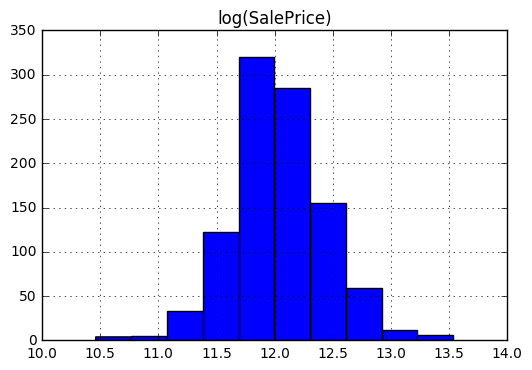

In [18]:
# Check log transform - looks good
%matplotlib inline
imputed_embedded_train['SalePrice'].log().as_data_frame().hist()

# Execute log transform
imputed_embedded_train['SalePrice'] = imputed_embedded_train['SalePrice'].log()
imputed_embedded_valid['SalePrice'] = imputed_embedded_valid['SalePrice'].log()
print(imputed_embedded_train[0:3, 'SalePrice'])

## Train GLM on imputed, embedded inputs

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.99]  Grid_GLM_py_10_sid_b0c9_model_python_1497984230119_13_model_3   
1     [0.5]  Grid_GLM_py_10_sid_b0c9_model_python_1497984230119_13_model_2   
2    [0.25]  Grid_GLM_py_10_sid_b0c9_model_python_1497984230119_13_model_1   
3    [0.01]  Grid_GLM_py_10_sid_b0c9_model_python_1497984230119_13_model_0   

    residual_deviance  
0  14.391996978991605  
1  14.505320931626205  
2  14.570709554467214  
3   22.12066522963339  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_10_sid_b0c9_model_python_1497984230119_13_model_3


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.032593634618016065
RMSE: 0.18053707269703934
MAE: 0.11681981624997378
RMSLE: 0.013868688006792928
R^2: 0.7898131898356927
Mean Residual Deviance: 0.032593634618016065
Null degrees of 

timestamp            duration    iteration    lambda    predictors    deviance_train        deviance_test
---  -------------------  ----------  -----------  --------  ------------  --------------------  --------------------
     2017-06-20 14:45:19  0.000 sec   0            .33E0     2             0.14499690535265583   0.15789472381332761
     2017-06-20 14:45:19  0.002 sec   0            .31E0     2             0.13581467150581084   0.14752358694970946
     2017-06-20 14:45:19  0.003 sec   0            .3E0      2             0.12744454455014284   0.1380396991297301
     2017-06-20 14:45:19  0.005 sec   0            .28E0     2             0.11981484855185137   0.1293661105906569
     2017-06-20 14:45:19  0.007 sec   0            .27E0     2             0.11286021422920539   0.12143258090813135
---  ---                  ---         ---          ---       ---           ---                   ---
     2017-06-20 14:45:20  0.210 sec   0            .41E-2    42            0.025084751957001026  0.0590915689259319
     2017-06-20 14:45:20  0.213 sec   0            .39E-2    43            0.025043356790260592  0.05965483807335217
     2017-06-20 14:45:20  0.217 sec   0            .37E-2    43            0.025005129020922556  0.060251485821032555
     2017-06-20 14:45:20  0.221 sec   0            .36E-2    44            0.02496660806337622   0.06081051123398236
     2017-06-20 14:45:20  0.224 sec   0            .34E-2    44            0.0249273797644446    0.061335336381312076


See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice predict 
 
 
 11.8494 11.9938 
 12.2061 12.2229 
 11.6784 11.7684 
 11.7906 11.9368 
 11.9117 11.8691 
 11.9767 12.0558 
 11.8451 11.6727 
 11.1346 11.4227 
 11.914 11.8427 
 11.8845 11.9904

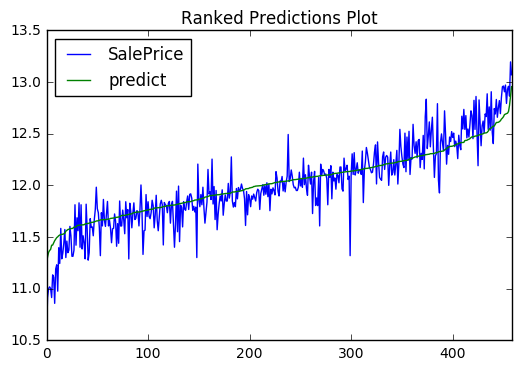

In [19]:
alpha_opts = [0.01, 0.25, 0.5, 0.99] # always keep some L2
hyper_parameters = {"alpha":alpha_opts}

# initialize grid search
grid = H2OGridSearch(
    H2OGeneralizedLinearEstimator(
        family="gaussian",
        lambda_search=True,
        seed=12345),
    hyper_params=hyper_parameters)
    
# train grid
grid.train(y='SalePrice',
           x=imputed_embedded_nums, 
           training_frame=imputed_embedded_train,
           validation_frame=imputed_embedded_valid)

# show grid search results
print(grid.show())

best = grid.get_grid()[0]
print(best)
    
# plot top frame values
yhat_frame = imputed_embedded_valid.cbind(best.predict(imputed_embedded_valid))
print(yhat_frame[0:10, ['SalePrice', 'predict']])

# plot sorted predictions
yhat_frame_df = yhat_frame[['SalePrice', 'predict']].as_data_frame()
yhat_frame_df.sort_values(by='predict', inplace=True)
yhat_frame_df.reset_index(inplace=True, drop=True)
_ = yhat_frame_df.plot(title='Ranked Predictions Plot')

In [20]:
# Shutdown H2O - this will erase all your unsaved frames and models in H2O
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? y
H2O session _sid_b0c9 closed.
